# Linear Regression with TensorFlow 2.0 APIs
This notebook demonstrates how to construct a linear regression model with the newest TensorFlow 2.0 APIs.

## Importing the packages

First, we need to install [TensorFlow 2.0](https://www.tensorflow.org/alpha/guide/effective_tf2) from PyPI. It's currently available as an alpha release ( as of May 2019 ). Also, we import the [Pandas](https://pandas.pydata.org/) and [NumPy](https://www.numpy.org/) packages along with [Scikit Learn's `train_test_split` module.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [1]:

import tensorflow as tf 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print( tf.__version__ )


2.0.0


**Note:**  Installing TensorFlow 2.0 can be an optional step if the Google Colab runtime has it by default. You can first check the TensorFlow version and then install TF 2.0 if necessary.

In [2]:
!pwd


/Users/dantongyu/Google Drive/Colab Notebooks


## Processing the Data
We download and preprocess our data for training and testing.

### Reading the CSV file with Pandas
We read the CSV file using [Pandas' `read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function and print the top 5 samples of the data.


In [3]:
!pwd
data = pd.read_csv('./graduate-admissions/Admission_Predict_Ver1.1.csv' )
data.head()


/Users/dantongyu/Google Drive/Colab Notebooks


Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

### Processing the CSV

We parse the values of the features from the Pandas `data` object. The steps are as follows:

1.   Read the values from the numeric/continuous features and normalize them by dividing with 100. ( `continuous_features` ) 
2.   Read the values from the binary feature. ( `categorical_research_feature` ) 
3.   Concatenate both the features types to form the final features array. ( `X` )
4.   Parse the label values. ( Y ) 
5.   Split the `X` and `Y` into training and validation datasets.
6.   Convert all the arrays to `tf.Tensor` objects.





In [4]:

continuous_features = data[ ['GRE Score','TOEFL Score','University Rating','SOP','LOR ','CGPA'] ].values / 100 # ----( 1 )
categorical_research_features = data[ [ 'Research' ] ].values # ----( 2 )

X = np.concatenate( [ continuous_features , categorical_research_features ] , axis=1 ) # ----( 3 )
Y = data[ [ 'Chance of Admit ' ] ].values # ----( 4 )

train_features , test_features ,train_labels, test_labels = train_test_split( X , Y , test_size=0.2 ) # ----( 5 )

#from sklearn.preprocessing import MinMaxScaler
# call MinMaxScaler object
#min_max_scaler = MinMaxScaler()

#train_features = min_max_scaler.fit(train_features).transform(train_features)

#test_features = min_max_scaler.fit(train_features).transform(test_features)



X = tf.constant( train_features , dtype=tf.float32 ) # -----|
Y = tf.constant( train_labels , dtype=tf.float32 ) # -------|
                                                           #|---( 6 )
test_X = tf.constant( test_features , dtype=tf.float32 ) #--|
test_Y = tf.constant( test_labels , dtype=tf.float32 ) # ---|

print(train_features)


[[3.32   1.18   0.05   ... 0.05   0.0964 1.    ]
 [3.17   1.06   0.02   ... 0.035  0.0812 0.    ]
 [3.29   1.1    0.02   ... 0.03   0.0915 1.    ]
 ...
 [3.28   1.15   0.04   ... 0.04   0.0916 1.    ]
 [3.07   1.05   0.02   ... 0.03   0.0765 0.    ]
 [3.15   1.04   0.03   ... 0.025  0.0833 0.    ]]


## Linear Regression model

We create various methods which help us in creating various components for our [linear regression model](https://machinelearningmastery.com/linear-regression-for-machine-learning/).


### Mean Squared Error and its derivative

We define a method which calculates the [mean squared error](https://www.freecodecamp.org/news/machine-learning-mean-squared-error-regression-line-c7dde9a26b93/) given the predictions and the expected outcomes.

$\Large MSE( y , \hat{y} ) = \frac{ \sum_{i=0}^{N} ( y_i - \hat{y}_i )^2 } { N }$

And its derivative,

$\Large MSE'( y , \hat{y} ) = \frac{ 2 * \sum_{i=0}^{N} ( y_i - \hat{y}_i ) } { N }$



In [5]:

def mean_squared_error( Y , y_pred ):
    return tf.reduce_mean( tf.square( y_pred - Y ) )

def mean_squared_error_deriv( Y , y_pred ):
    return tf.reshape( tf.reduce_mean( 2 * ( y_pred - Y ) ) , [ 1 , 1 ] )


### Hypothesis function (  Regression function )

We define the hypothesis function *h* which takes in the weights and the bias and outputs the *Y* value for the given value of *X*.

$\Large h( x ) = W.X + B$

where $W$ and $X$ are the parameters which are going to optimize by [Gradient Descent](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html).



In [6]:

def h ( X , weights , bias ):
    return tf.tensordot( X , weights , axes=1 ) + bias


### Defining hyperparameters and `tf.data.Dataset`
We define two hyperparameters which will affect our training process.

*   Batch Size $\to$ The size of the mini-batch used in mini-batch gradient descent.
*   Learning Rate $\to$ The scalar value which scales the step size of the gradients.

Also, for effective mini-batch training, we create a [`tf.data.Dataset`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset) object which holds and batches our data tensors.





In [7]:

num_epochs = 20
num_samples = X.shape[0]
batch_size = 10
learning_rate = 0.005

dataset = tf.data.Dataset.from_tensor_slices(( X , Y )) 
dataset = dataset.shuffle( 500 ).repeat( num_epochs ).batch( batch_size )
iterator = dataset.__iter__()


### Training the model

We train the model for a given number of epochs. We perform optimization for every batch in our dataset.

Forward Propogation, to calculate the loss, is as follows,

$\Large loss = MSE( W.X + b ) $

To optimize the parameter $W$, the partial derivative of $MSE$ with respect to $W$ will be,


$\Large \frac{ \partial MSE }{ \partial W} = \frac{ \partial MSE }{ \partial h} \frac{ \partial h }{ \partial W}$

Similarly for bias $b$ , 

$\Large \frac{ \partial MSE }{ \partial b} = \frac{ \partial MSE }{ \partial h} $


In [8]:

num_features = X.shape[1]
weights = tf.random.normal( ( num_features , 1 ) ) 
bias = 0

epochs_plot = list()
loss_plot = list()

for i in range( num_epochs ) :
    
    epoch_loss = list()
    for b in range( int(num_samples/batch_size) ):
        x_batch , y_batch = iterator.get_next()
   
        output = h( x_batch , weights , bias ) 
        loss = epoch_loss.append( mean_squared_error( y_batch , output ).numpy() )
    
        dJ_dH = mean_squared_error_deriv( y_batch , output)
        dH_dW = x_batch
        dJ_dW = tf.reduce_mean( dJ_dH * dH_dW )
        dJ_dB = tf.reduce_mean( dJ_dH )
    
        weights -= ( learning_rate * dJ_dW )
        bias -= ( learning_rate * dJ_dB ) 
        
    loss = np.array( epoch_loss ).mean()
    epochs_plot.append( i + 1 )
    loss_plot.append( loss ) 
    
    print( 'Loss is {}'.format( loss ) ) 
    

Loss is 0.7676973938941956
Loss is 0.04153641313314438
Loss is 0.022437075152993202
Loss is 0.02167898789048195
Loss is 0.02165890857577324
Loss is 0.021470937877893448
Loss is 0.021644387394189835
Loss is 0.021530773490667343
Loss is 0.021578479558229446
Loss is 0.021582409739494324
Loss is 0.02145201526582241
Loss is 0.02157357521355152
Loss is 0.021497009322047234
Loss is 0.021532082930207253
Loss is 0.02140684798359871
Loss is 0.021429704502224922
Loss is 0.021457789465785027
Loss is 0.021496515721082687
Loss is 0.02141885831952095
Loss is 0.021393347531557083


### Plotting the epoch-loss graph

We plot a simple graph which shows us the decrease in loss with increasing epochs.

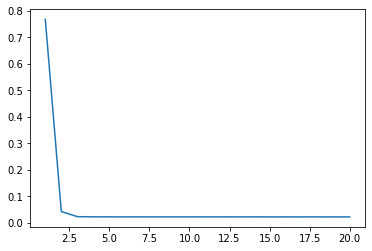

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot( epochs_plot , loss_plot ) 
plt.show()



## Evaluating the model

We evaluate our model's performance by measuring the [Mean Absolute Error](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html?highlight=mean%20absolute#mae-l1) on the validation dataset.

In [10]:

output = h( test_X , weights , bias ) 
labels = test_Y



accuracy_op = tf.metrics.MeanAbsoluteError() 
accuracy_op.update_state( labels , output )
print( 'Mean Absolute Error = {}'.format( accuracy_op.result().numpy() ) )


Mean Absolute Error = 0.11168064177036285


In [60]:
for i, j in zip(test_Y.numpy(), output.numpy()):
    print(i,j)

[0.66] [0.7604561]
[0.7] [0.73027396]
[0.71] [0.7286134]
[0.61] [0.6827464]
[0.76] [0.7479005]
[0.64] [0.7188683]
[0.58] [0.76048064]
[0.86] [0.7146329]
[0.46] [0.68304086]
[0.56] [0.63808405]
[0.72] [0.73792493]
[0.59] [0.73353124]
[0.68] [0.7003664]
[0.54] [0.703833]
[0.86] [0.71184003]
[0.9] [0.728744]
[0.59] [0.73721313]
[0.69] [0.7489267]
[0.68] [0.6450428]
[0.97] [0.75311524]
[0.58] [0.72037834]
[0.69] [0.65074515]
[0.81] [0.6987153]
[0.7] [0.7217026]
[0.95] [0.74615043]
[0.78] [0.6759745]
[0.93] [0.7282177]
[0.82] [0.7150916]
[0.56] [0.7111782]
[0.92] [0.6853771]
[0.7] [0.6499057]
[0.75] [0.7358899]
[0.83] [0.77623105]
[0.73] [0.6411051]
[0.66] [0.7476091]
[0.62] [0.770082]
[0.66] [0.65656805]
[0.52] [0.73078704]
[0.79] [0.71906066]
[0.77] [0.77885115]
[0.93] [0.74580425]
[0.62] [0.71872205]
[0.97] [0.7486002]
[0.94] [0.7274146]
[0.89] [0.7052613]
[0.9] [0.74100363]
[0.57] [0.6646017]
[0.81] [0.69627124]
[0.77] [0.7215682]
[0.87] [0.6682809]
[0.86] [0.73133355]
[0.92] [0.6928333

In [54]:


#for i in zip((labels.numpy, output.numpy)):
 #   print(i)
  

SyntaxError: invalid syntax (<ipython-input-54-695662de88d4>, line 1)